<h1 style="text-align: center; font-weight: bold; font-size: 36px;">Building a WaveNet</h1>

# Introduction

Let's create a **MLP** model. Explore training and debugging techniques.

Inspired by Karpathy [Neural Networks: Zero-to-Hero](https://github.com/karpathy/nn-zero-to-hero). 
We are using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) as in Zero to Hero so we can compare results.

# Imports

In [29]:
import time
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# PyTorch-ify

In [5]:
class Tokenizer:
    def __init__(self, vocab):
        assert isinstance(vocab, list)
        assert all(isinstance(v, str) for v in vocab)
        assert all(len(v) == 1 for v in vocab)
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}

    def encode(self, text):
        return [self.stoi[s] for s in text]

    def decode(self, sequence):
        if isinstance(sequence, list):
            return ''.join([self.itos[i] for i in sequence])
        elif isinstance(sequence, torch.Tensor):
            assert sequence.ndim in [0, 1]
            if sequence.ndim == 0:
                return self.itos[sequence.item()]  # one char
            else:
                return ''.join([self.itos[i.item()] for i in sequence])
        else:
            raise ValueError(f"Type {type(sequence)} not supported")

# Build the Dataset

In [6]:
with open('../data/names.txt', 'r') as f:
    names = f.read().splitlines()
print("Num names:", len(names))
print("Example names:", names[:10])
print("Min length:", min(len(name) for name in names))
print("Max length:", max(len(name) for name in names))

Num names: 32033
Example names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Min length: 2
Max length: 15


In [7]:
# Get vocabulary
letters = sorted(list(set(''.join(names))))
letters = ['.'] + letters
n_vocab = len(letters)
print(letters)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
def build_dataset(tok, n_seq, names):
    X, Y = [], []  # inputs and targets
    for name in names:
        name = '.'*n_seq + name + '.'  # add start/stop tokens '..emma.'
        for i in range(len(name) - n_seq):
            X.append(tok.encode(name[i:i+n_seq]))
            Y.append(tok.encode(name[i+n_seq])[0])  # [0] to keep Y 1d tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [9]:
n_seq = 8  # context length
tok = Tokenizer(vocab=letters)

random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(tok, n_seq, names[:n1])
Xval, Yval = build_dataset(tok, n_seq, names[n1:n2])
Xtest, Ytest = build_dataset(tok, n_seq, names[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [10]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(tok.decode(x), tok.decode(y))

........ y
.......y u
......yu h
.....yuh e
....yuhe n
...yuhen g
..yuheng .
........ d
.......d i
......di o
.....dio n
....dion d
...diond r
..diondr e
.diondre .
........ x
.......x a
......xa v
.....xav i
....xavi e


# Build the Model

In [11]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features)) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)
        
        self.mean_running = torch.zeros(dim)
        self.var_running = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            x_mean = torch.mean(x, dim=dim, keepdim=True)
            x_var = torch.var(x, dim=dim, keepdim=True)
            with torch.no_grad():
                self.mean_running = (1-self.momentum) * self.mean_running + self.momentum * x_mean
                self.var_running = (1-self.momentum) * self.var_running + self.momentum * x_var
        else:
            x_mean = self.mean_running
            x_var = self.var_running
        zx = (x - x_mean) / (x_var + self.eps)**0.5  # sqrt
        self.out = zx * self.gain + self.bias
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]

class Tanh:
    def __init__(self):
        pass

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        n_batch, n_seq, n_emb = x.shape
        x = x.view(n_batch, n_seq//self.n, n_emb*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)  # last conv n_seq==2, self.n==2, remove extra dim
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def train(self):
        for l in self.layers: l.training = True

    def eval(self):
        for l in self.layers: l.training = False
    

In [12]:
# Expected initial loss:
expected_initial_loss = -1 * torch.tensor(1/n_vocab).log()
print(expected_initial_loss)

tensor(3.2958)


In [39]:
# Experiments:
# - play with kaming init: 5/3
# - play with weight init in Linear: / (in_features**0.5)

# Random Init
torch.manual_seed(42)

# Hyperparameters


# Model
# n_embd = 10
# n_hidden = 200
# model = Sequential([  # 22097
#     Embedding(n_vocab, n_embd),
#     FlattenConsecutive(n=8),
#     Linear(n_embd*n_seq, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_vocab),
# ])


# n_embd = 10
# n_hidden = 68
n_embd = 24
n_hidden = 128
model = Sequential([
    Embedding(n_vocab, n_embd),
    FlattenConsecutive(n=2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_vocab),
])

# Parameter Init
with torch.no_grad():
    model.layers[-1].weight *= 0.1     # last layer less confident for uniform softmax

# Gather Params
params = model.parameters()

# Enable Grad
for p in params:
    p.requires_grad = True

# Total Num Params
print(sum(p.nelement() for p in params))

76579


In [43]:
batch_indices = torch.randint(0, Xtr.shape[0], (32,))
x_batch, y_batch = Xtr[batch_indices], Ytr[batch_indices]
logits = model(x_batch)

In [44]:
for i in range(len(model.layers)):
    print(f"{model.layers[i].__class__.__name__:>20}({str(i):<2}): {tuple(model.layers[i].out.shape)}")

           Embedding(0 ): (32, 8, 24)
  FlattenConsecutive(1 ): (32, 4, 48)
              Linear(2 ): (32, 4, 128)
         BatchNorm1d(3 ): (32, 4, 128)
                Tanh(4 ): (32, 4, 128)
  FlattenConsecutive(5 ): (32, 2, 256)
              Linear(6 ): (32, 2, 128)
         BatchNorm1d(7 ): (32, 2, 128)
                Tanh(8 ): (32, 2, 128)
  FlattenConsecutive(9 ): (32, 256)
              Linear(10): (32, 128)
         BatchNorm1d(11): (32, 128)
                Tanh(12): (32, 128)
              Linear(13): (32, 27)


In [45]:
iters, losses, ud = [], [], []

lr_schedule = [0.1]*150_000 + [0.01]*50_000
num_epochs = len(lr_schedule)
n_batch = 32
i = 0

In [46]:
time_start = time.time()
for _ in range(num_epochs):

    # Set Mode
    model.train()

    # Mini Batch
    batch_indices = torch.randint(0, Xtr.shape[0], (n_batch,))
    x_batch, y_batch = Xtr[batch_indices], Ytr[batch_indices]

    # Forward
    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)

    # Backward
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update
    lr = lr_schedule[i]
    for p in params:
        p.data += -lr * p.grad

    # Stats
    if i % 10000 == 0:
        time_taken = time.time() - time_start
        time_start = time.time()
        print(f"{time_taken:.2f}  {i}  {loss.item()}")
    iters.append(i)
    losses.append(loss.item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in params])

    # Break
    # if i % 10_000 == 0:
    #     break
    # break

    i += 1

print(i, loss.item())

0.01  0  3.3055202960968018
35.69  10000  1.9842808246612549
35.06  20000  1.745496392250061
35.04  30000  2.31596040725708
35.36  40000  2.2801318168640137
35.51  50000  1.601252794265747
35.77  60000  2.2458691596984863
35.07  70000  1.7933542728424072
34.61  80000  1.5476984977722168
35.69  90000  1.8936344385147095
35.67  100000  1.9824970960617065
35.60  110000  2.0499188899993896
35.72  120000  1.9841783046722412
35.08  130000  1.949601173400879
35.60  140000  2.2059340476989746
35.82  150000  1.8846684694290161
35.06  160000  1.9877268075942993
35.33  170000  1.8880400657653809
34.18  180000  1.8935978412628174
35.25  190000  1.6366466283798218
200000 2.2015621662139893


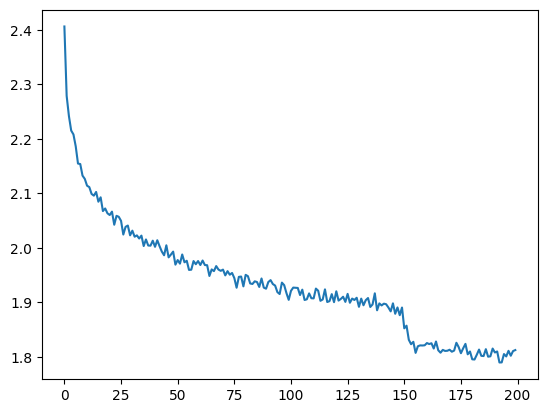

In [47]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(dim=-1))
plt.show()

In [48]:
@torch.no_grad()
def evaluate(x_batch, y_batch):
    model.eval()
    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)
    return loss.item()

print("train = ", evaluate(Xtr, Ytr))    # ~2.12
print("eval =  ", evaluate(Xval, Yval))  # ~2.15

train =  1.7685450315475464
eval =   1.9916802644729614


In [ ]:
# Performance Log

# Basic MLP, context: 3, n_hidden: 200, params: 12k
# train =  2.0585014820098877
# eval =   2.1086041927337646

# Basic MLP, context: 8, n_hidden: 200, params: 22k
# train =  1.9192137718200684
# eval =   2.034139394760132

# ConvNet, context: 8, n_hidden: 68, params: 22k
# train =  1.9116861820220947
# eval =   2.0205955505371094

# ConvNet, context: 8, n_embd: 24, n_hidden: 128, params: 76k
# train =  1.7685450315475464
# eval =   1.9916802644729614

In [22]:
@torch.no_grad()
def sample_name():
    model.eval()    
    context = tok.encode('.'*n_seq)
    while True:
        x = torch.tensor(context[-3:]).view(1, -1)   # n_batch=1, n_seq
        # Forward Pass
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        # Sample
        sample = torch.multinomial(probs, 1).item()
        context.append(sample)
        # Break
        if sample == 0:  # stop token
            break

    return tok.decode(context)[n_seq:]

In [23]:
torch.manual_seed(42)

for i in range(10):
    print(sample_name())

anuelen.
tis.
marian.
dante.
naysia.
aley.
kemah.
lucin.
epiachaleilanzi.
kendrickeyon.
